In [1]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


/tmp/ipykernel_9438/1607120126.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


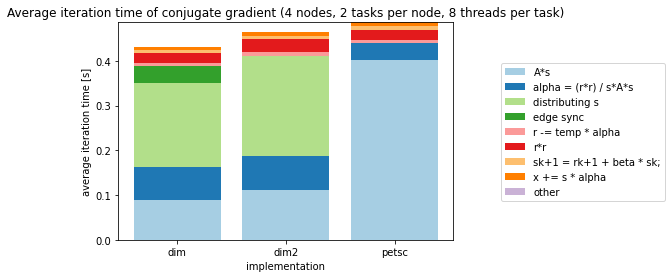

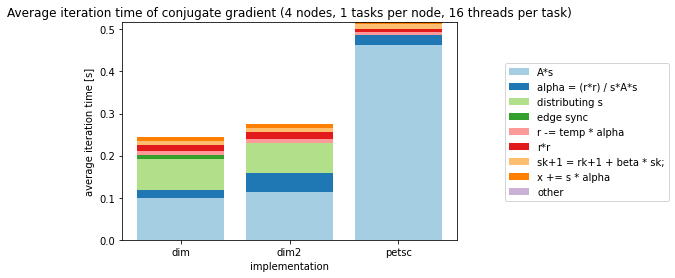

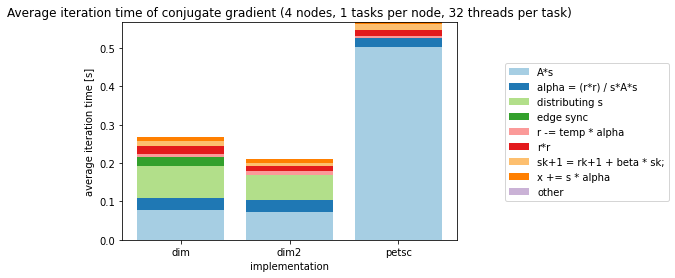

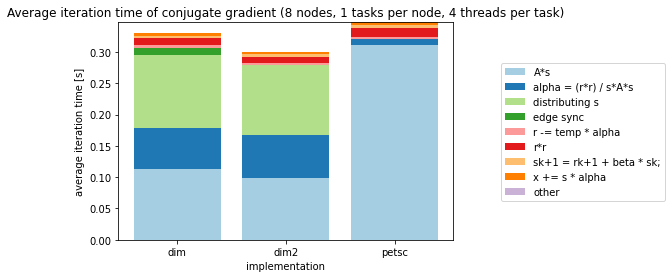

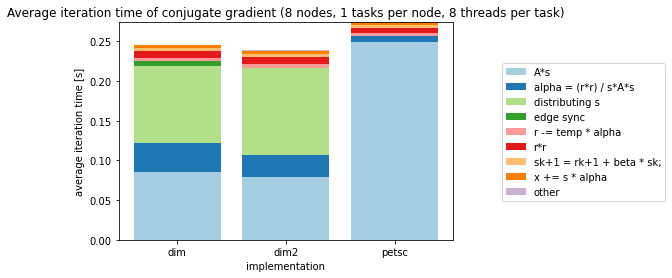

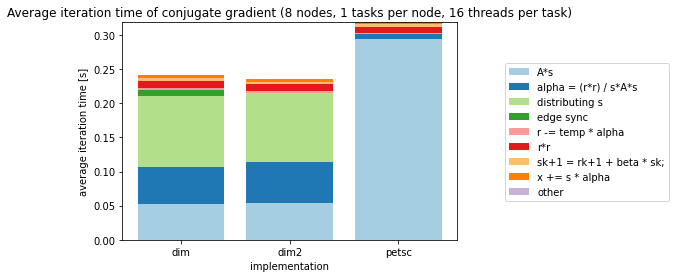

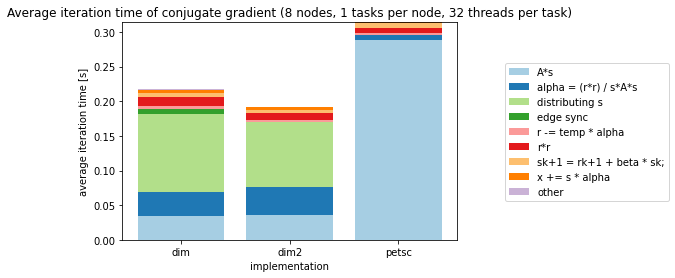

In [31]:
import json
from pathlib import Path


def load_json(path):
    with open(path) as fin:
        return json.load(fin)


def load_stats(directory):
    directory = Path(directory)
    files = [*directory.glob("stats_*.json")]

    result = load_json(files[0])

    for file in files[1:]:
        j = load_json(file)
        result["total"] += j["total"]

        for step, length in j["cg"]["steps"].items():
            result["cg"]["steps"][step] += length
        result["cg"]["total"] += j["cg"]["total"]

    result["total"] /= len(files)
    for step, length in j["cg"]["steps"].items():
        result["cg"]["steps"][step] /= len(files)
    result["cg"]["total"] /= len(files)

    return result


def normalize(stats):
    other = stats["cg"]["total"] - sum(stats["cg"]["steps"].values())
    if other > 0:
        stats["cg"]["steps"]["other"] = other

    for key in stats["cg"]["steps"]:
        stats["cg"]["steps"][key] /= stats["cg"]["num_iters"]


def get_color(step, colors={}, next_color=[0]):
    if step not in colors:
        colors[step] = plt.cm.Paired(next_color)
        next_color[0] += 1

    return colors[step]


def plot_one(ax, stats, offset):
    bottom = 0
    for step, value in stats["cg"]["steps"].items():
        ax.bar(
            offset, value, bottom=bottom, label=step, width=0.4, color=get_color(step)
        )
        bottom += value


def plot_run(matrix="gap-web", layout="8-1-8"):
    dim = load_stats(f"../../resources/benchmark_data/cg_dim/{matrix}/{layout}")
    dim2 = load_stats(f"../../resources/benchmark_data/cg_dim2/{matrix}/{layout}")
    petsc = load_stats(f"../../resources/benchmark_data/cg_petsc/{matrix}/{layout}")


    normalize(dim)
    normalize(dim2)
    normalize(petsc)

    fig, ax = plt.subplots(1, 1)

    plot_one(ax, dim, 0)
    plot_one(ax, dim2, 0.5)
    plot_one(ax, petsc, 1)

    nodes, tasks_per_node, threads = layout.split("-", maxsplit=3)

    ax.set_xticks(np.arange(3) * 0.5, ["dim", "dim2", "petsc"])
    ax.set_xlabel("implementation")
    ax.set_ylabel("average iteration time [s]")
    ax.set_title(
        f"Average iteration time of conjugate gradient ({nodes} nodes, {tasks_per_node} tasks per node, {threads} threads per task)"
    )

    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    lgd = fig.legend(
        by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
    )

    fig.show()


plot_run(layout="4-2-8")
plot_run(layout="4-1-16")
plot_run(layout="4-1-32")
plot_run(layout="8-1-4")
plot_run(layout="8-1-8")
plot_run(layout="8-1-16")
plot_run(layout="8-1-32")


In [ ]:
input_files = ['../../resources/matrices/e40r5000.mtx',
               '../../resources/matrices/Serena/Serena.mtx',
               '../../resources/matrices/Flan_1565/Flan_1565.mtx',
               '../../resources/matrices/nlpkkt200/nlpkkt200.mtx',
               ]

uns_input_files = ['../../resources/matrices/e40r5000.mtx',
                   '../../resources/matrices/Serena/Serena.uns.mtx',
                   '../../resources/matrices/Flan_1565/Flan_1565.uns.mtx',
                   '../../resources/matrices/nlpkkt200/nlpkkt200.uns.mtx',
                   ]

h5_comp_files = ['../../resources/matrices/e40r5000.comp.csr.h5',
                 '../../resources/matrices/Serena/Serena.comp.csr.h5',
                 '../../resources/matrices/Flan_1565/Flan_1565.comp.csr.h5',
                 '../../resources/matrices/nlpkkt200/nlpkkt200.comp.csr.h5',
                 ]

h5_csr5_files = ['../../resources/matrices/e40r5000.csr5.h5',
                 '../../resources/matrices/Serena/Serena.csr5.h5',
                 '../../resources/matrices/Flan_1565/Flan_1565.csr5.h5',
                 '../../resources/matrices/nlpkkt200/nlpkkt200.csr5.h5',
                 ]

h5_input_files = [file.replace('.mtx', '.csr.h5') for file in input_files]


In [ ]:
import os
from pathlib import Path


def gen_sizes(paths):
    return np.array([Path(file).stat().st_size for file in paths]) / (1024 * 1024)


sizes = np.array([553956, 64531701, 117406044, 448225632])
x_axis = np.arange(4)

col_width = 0.15

half_col = col_width / 2
padding = 0.015

offset = half_col + padding

first_col_off = (half_col + padding/2)
second_col_off = first_col_off + padding + 2*half_col

h5_comp_sizes = gen_sizes(h5_comp_files)
h5_sizes = gen_sizes(h5_input_files)
mmef_sizes = gen_sizes(input_files)
mmef_uns_sizes = gen_sizes(uns_input_files)
h5_csr5_sizes = gen_sizes(h5_csr5_files)

plt.bar(x_axis - second_col_off, h5_comp_sizes, col_width, label='H5_comp')
plt.bar(x_axis - first_col_off, h5_sizes, col_width, label='H5')
plt.bar(x_axis + first_col_off, mmef_sizes, col_width, label='MMEF')
plt.bar(x_axis + second_col_off, mmef_uns_sizes, col_width, label='MMEF_uns')

plt.ylabel("On disk size [MiB]")

plt.xticks(x_axis, sizes)
plt.xlabel("Size of matrix [#non-zero elements]")

plt.legend()

plt.savefig('storage_sizes.png')
plt.show()


In [ ]:

plt.bar(x_axis - first_col_off, h5_sizes, col_width, label='CSR')
plt.bar(x_axis + first_col_off, h5_csr5_sizes, col_width, label='CSR5')

plt.ylabel("On disk size [MiB]")

plt.xticks(x_axis, sizes)
plt.xlabel("Size of matrix [#non-zero elements]")

plt.legend()

plt.savefig('storage_sizes.png')
plt.show()

In [ ]:
scanf = np.array([0.276,
                  13.081,
                  25.000,
                  69.779])

scnlib = np.array([0.195,
                   9.747,
                   16.939,
                   56.880])

h5 = np.array([0.012080481,
               0.380540722,
               1.444768292,
               3.127314214])

h5_comp = np.array([0.038764978,
                    2.915186758,
                    3.299717415,
                    12.350463458])


scanf_throughput = sizes / scanf
scnlib_throughput = sizes / scnlib
h5_throughput = sizes / h5
h5_comp_throughput = sizes / h5_comp

scanf_avg_thr = np.average(scanf_throughput)
scnlib_avg_thr = np.average(scnlib_throughput)
h5_avg_thr = np.average(h5_throughput)
h5_comp_avg_thr = np.average(h5_comp_throughput)

print(scanf_throughput, scanf_avg_thr)
print(scnlib_throughput, scnlib_avg_thr)
print(h5_throughput, h5_avg_thr)
print(h5_comp_throughput, h5_comp_avg_thr)

print(scnlib_avg_thr / scanf_avg_thr, h5_avg_thr /
      scanf_avg_thr, h5_avg_thr / scnlib_avg_thr, h5_avg_thr / h5_comp_avg_thr)

print(h5_comp_avg_thr / scnlib_avg_thr, h5_comp_avg_thr / scanf_avg_thr)

X_axis = np.arange(4)

plt.bar(X_axis - second_col_off, h5, col_width, label='h5')
plt.bar(X_axis - first_col_off, h5_comp, col_width, label='h5_comp')
plt.bar(X_axis + first_col_off, scnlib, col_width, label='scnlib')
plt.bar(X_axis + second_col_off, scanf, col_width, label='scanf')
plt.xticks(X_axis, sizes)
plt.xlabel("Size of matrix [#non-zero elements]")
plt.ylabel("Loading time [s]")
plt.title("")
plt.legend()
plt.savefig('matrix_loading.png')
plt.show()


In [ ]:
print(h5_sizes)
print(h5_comp_sizes)

display(h5_sizes / h5_comp_sizes)
display(mmef_sizes / h5_comp_sizes)